In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#forked to learn the 'input
from subprocess import check_output
import subprocess
# print(check_output(["ls","input"],shell=True,stderr=subprocess.STDOUT,).decode("utf8"))
from sklearn.neural_network import MLPClassifier
import h5py
from scipy import sparse
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
print("Modules imported!")
print("Collecting Data...")
hf = h5py.File("input/cdk2.h5", "r")
ids = hf["chembl_id"] # the name of each molecules


Modules imported!


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
labels = hf["label"] # the label of each molecule
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [4]:
labels

<HDF5 dataset "label": shape (1890,), type "<i8">

In [5]:
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix

def cosine(plays):
    normalized = normalize(plays)
    return normalized.dot(normalized.T)


def bhattacharya(plays):
    plays.data = np.sqrt(plays.data)
    return cosine(plays)


def ochiai(plays):
    plays = csr_matrix(plays)
    plays.data = np.ones(len(plays.data))
    return cosine(plays)


def bm25_weight(data, K1=1.2, B=0.8):
    """ Weighs each row of the matrix data by BM25 weighting """
    # calculate idf per term (user)
    N = float(data.shape[0])
    idf = np.log(N / (1 + np.bincount(data.col)))

    # calculate length_norm per document (artist)
    row_sums = np.squeeze(np.asarray(data.sum(1)))
    average_length = row_sums.sum() / N
    length_norm = (1.0 - B) + B * row_sums / average_length

    # weight matrix rows by bm25
    ret = coo_matrix(data)
    ret.data = ret.data * (K1 + 1.0) / (K1 * length_norm[ret.row] + ret.data) * idf[ret.col]
    return ret


def bm25(plays):
    plays = bm25_weight(plays)
    return plays.dot(plays.T)

def get_largest(row, N=10):
    if N >= row.nnz:
        best = zip(row.data, row.indices)
    else:
        ind = np.argpartition(row.data, -N)[-N:]
        best = zip(row.data[ind], row.indices[ind])
    return sorted(best, reverse=True)


def calculate_similar_artists(similarity, artists, artistid):
    neighbours = similarity[artistid]
    top = get_largest(neighbours)
    return [(artists[other], score, i) for i, (score, other) in enumerate(top)]



similarity = bm25(coo_matrix(features)).todense()

similarity

matrix([[1081.06364495,   90.18583029,   42.32094192, ...,   80.48898524,
           78.47186794,   82.09391297],
        [  90.18583029, 1008.21046951,  101.51321267, ...,  125.45888792,
          103.52277725,  146.84308866],
        [  42.32094192,  101.51321267, 1457.0755857 , ...,  137.73886646,
          458.1301387 ,  275.72155783],
        ...,
        [  80.48898524,  125.45888792,  137.73886646, ..., 3472.66003308,
          154.32427957,  182.3394268 ],
        [  78.47186794,  103.52277725,  458.1301387 , ...,  154.32427957,
         3038.38008702,  504.99802758],
        [  82.09391297,  146.84308866,  275.72155783, ...,  182.3394268 ,
          504.99802758, 1790.79614242]])

In [6]:
U, sigma, Vt = np.linalg.svd(similarity[:,:200], full_matrices=False)
sigma = np.diag(sigma)
print(U.shape,sigma.shape,Vt.shape)

(1890, 200) (200, 200) (200, 200)


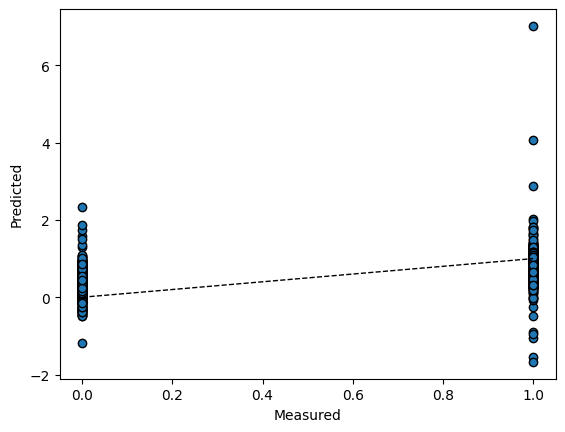

0.18798174172396198


In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

nplabels = labels[:]

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, U, nplabels, cv=5)

fig, ax = plt.subplots()
ax.scatter(nplabels, predicted, edgecolors=(0, 0, 0))
ax.plot([nplabels.min(), nplabels.max()], [nplabels.min(), nplabels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

from sklearn.metrics import r2_score
print(r2_score(nplabels, predicted))

In [64]:
from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.preprocessing import MinMaxScaler

# import some data to play with
       # those ? converted to NAN are bothering me abit...

from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,roc_curve,RocCurveDisplay, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

X = U
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)


Y=labels[:]


names = [
         'ElasticNet',
         'SVC',
         'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         'GridSearchCV',
         'HuberRegressor',
         'Ridge',
         'Lasso',
         'LassoCV',
         'Lars',
         'BayesianRidge',
         'SGDClassifier',
         'RidgeClassifier',
         'LogisticRegression',
         'OrthogonalMatchingPursuit',
         ]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
    LogisticRegression(),
    OrthogonalMatchingPursuit(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

temp=zip(names,classifiers,correction)
print(temp)

results = {}

for name, clf,correct in temp:
    regr=clf.fit(X,Y)
    #print( name,'% errors', abs(regr.predict(X)+correct-Y).sum()/(Y.sum())*100)
    y_pred = regr.predict(X)
    print(name,'%error',procenterror(y_pred,Y),'rmsle',rmsle(y_pred,Y))
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

    # Confusion Matrix
    print(name,'Confusion Matrix')
    matrix = confusion_matrix(Y, np.round(regr.predict(X) ) )
    print( matrix )
    print('--'*40)

    # Classification Report
    print('Classification Report')
    report = classification_report(Y,np.round( regr.predict(X) ) )
    print(report)

    # Accuracy
    print('--'*40)
    logreg_accuracy = round(accuracy_score(Y, np.round( regr.predict(X) ) ) * 100,2)
    print('Accuracy', logreg_accuracy,'%')


    # Save it to results
    results[name] = {
        "report" : report,
        "matrix" : matrix,
        "logreg_accuracy" : logreg_accuracy,
        "y_pred" : y_pred,
    }


ElasticNet %error 38.2 rmsle 0.23125134250382468
ElasticNet Confusion Matrix
[[ 414  205]
 [  55 1216]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       619
           1       0.86      0.96      0.90      1271

    accuracy                           0.86      1890
   macro avg       0.87      0.81      0.83      1890
weighted avg       0.86      0.86      0.86      1890

--------------------------------------------------------------------------------
Accuracy 86.24 %
SVC %error 11.5 rmsle 0.1926508754335712
SVC Confusion Matrix
[[ 494  125]
 [  21 1250]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       619
           1       0.91      0.98      0.94      1271

    accuracy

In [65]:
def roc_plot_from_res(results):
    fig, ax = plt.subplots(figsize=(10, 12))
    for name, feature in results.items():
        y_pred = feature["y_pred"]
        RocCurveDisplay.from_predictions(Y, y_pred, ax=ax, name='{} auc: {}'.format(name,feature["logreg_accuracy"]))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

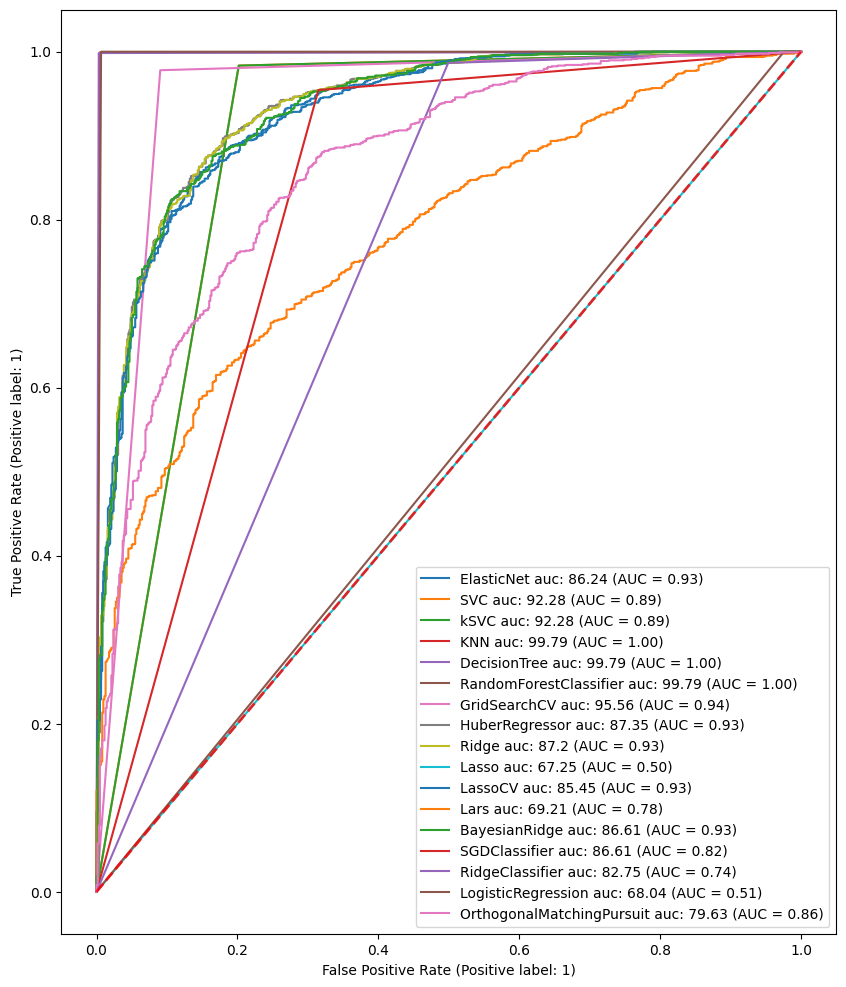

In [66]:
roc_plot_from_res(results)

In [67]:
treshold = 90
below_res = {}
above_res = {}

In [68]:
for name, feature in results.items():
    if feature["logreg_accuracy"] <= treshold:
        below_res[name] = feature
    else:
        above_res[name] = feature

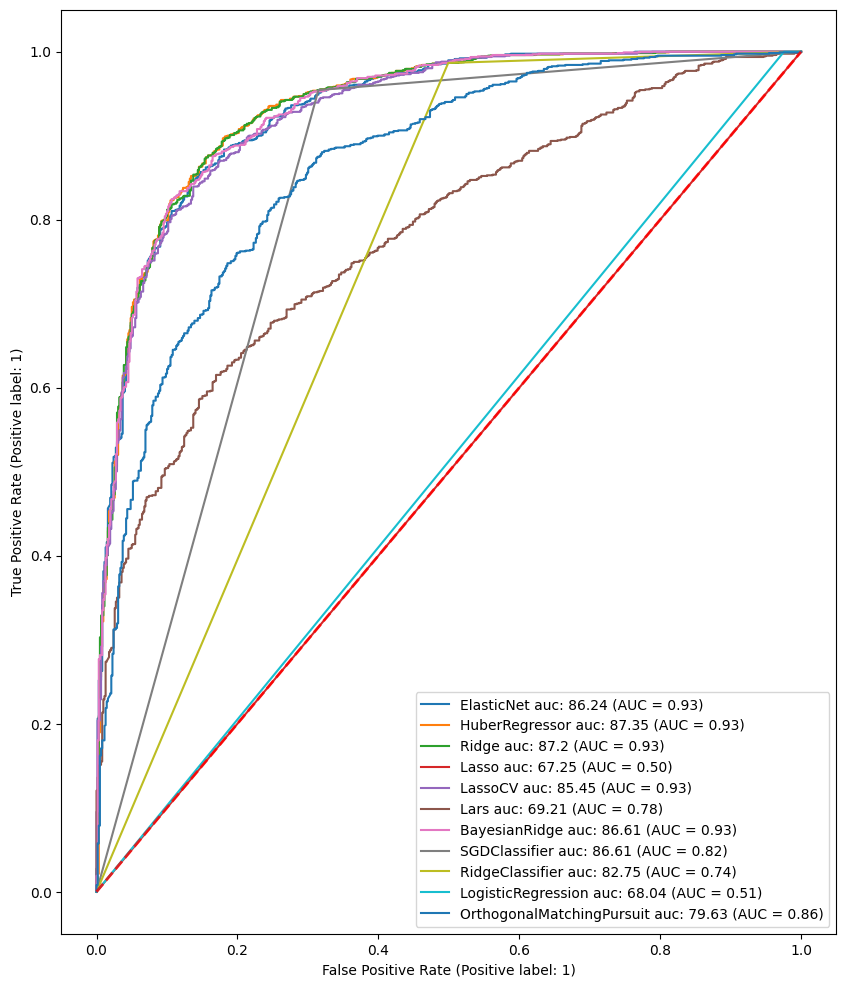

In [69]:
roc_plot_from_res(below_res)

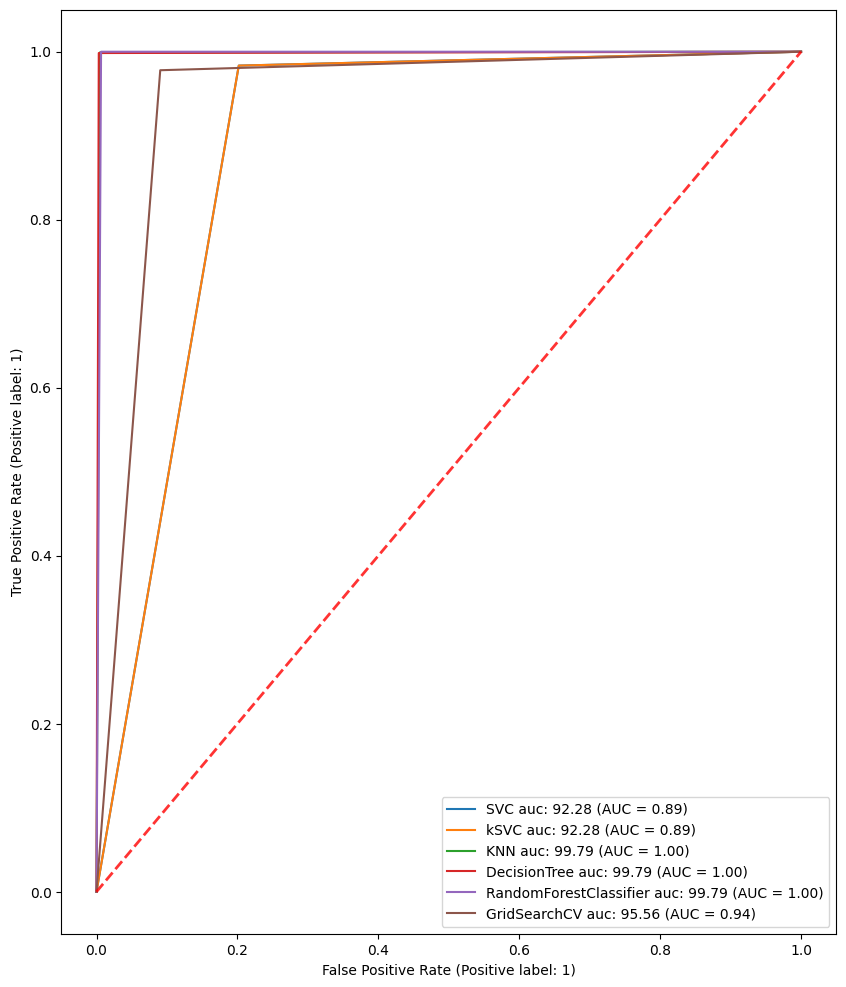

In [70]:
roc_plot_from_res(above_res)

In [86]:
def matrix_plot_from_res(results):
    for name, feature in results.items():
        fig, ax = plt.subplots()
        ax.legend = name
        fig.suptitle("Classifier: " + name)
        sns.heatmap(pd.DataFrame(feature["matrix"]), annot=True, cmap='Reds',ax=ax,fmt='g')
        plt.show()

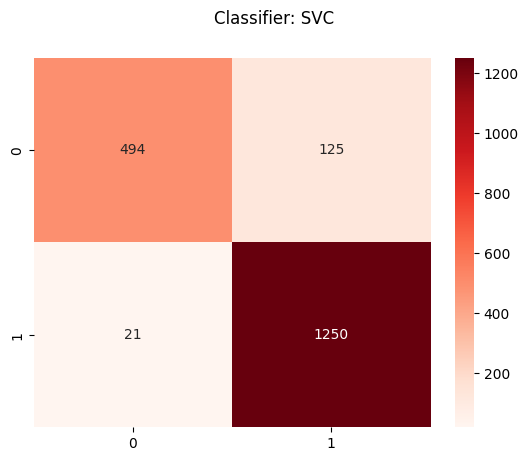

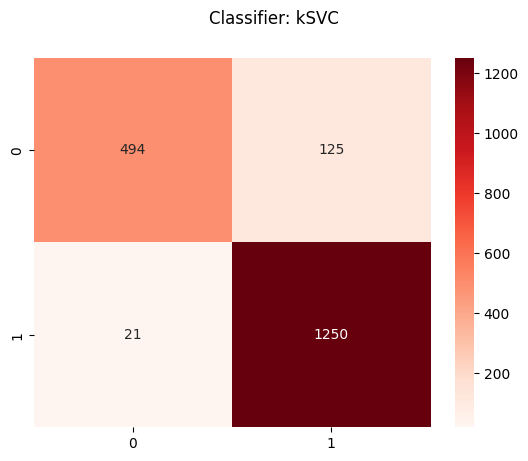

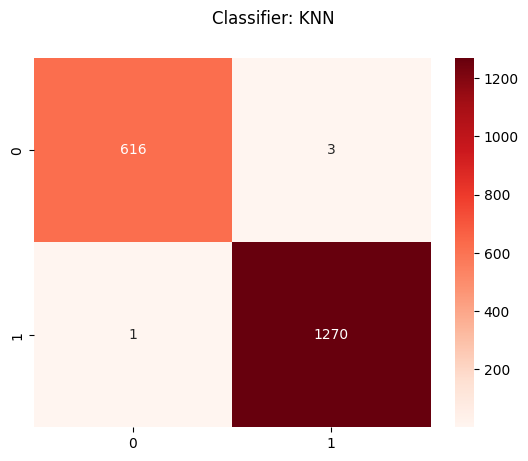

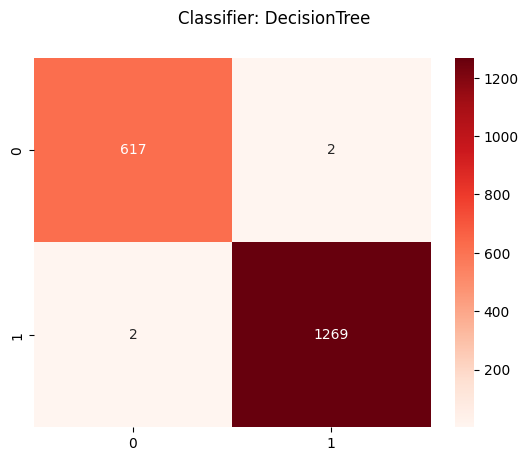

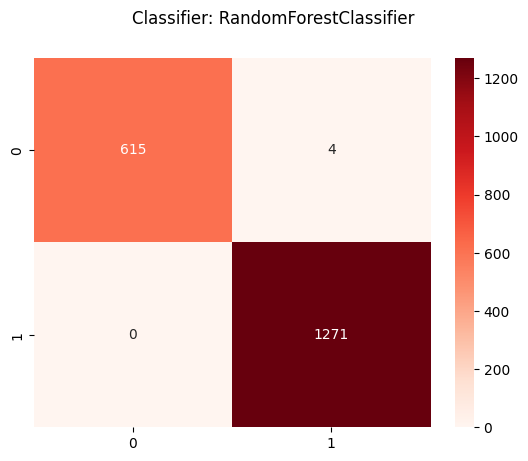

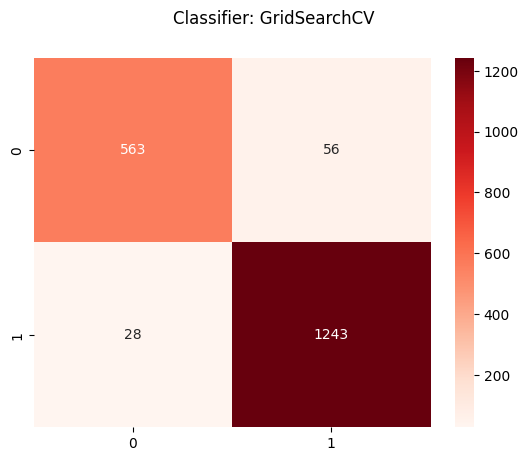

In [87]:
matrix_plot_from_res(above_res)